Reference: [this colab pytorch implementation](https://colab.research.google.com/drive/18EyozusBSgxa5oUBmlzXrp9fEbPyOUoC)

In [ ]:
!git clone https://github.com/tkipf/pygcn.git

In [1]:
import sys
sys.path.insert(0,'pygcn')

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from pygcn.utils import accuracy
import torch
from torch import nn, optim
from torch.utils import data

In [3]:
from pygcn.utils import load_data
adj, features, labels, idx_train, idx_val, idx_test = load_data(path='pygcn/data/cora/')

Loading cora dataset...


In [4]:
print(features.shape, adj.shape, labels.shape, torch.max(labels))

torch.Size([2708, 1433]) torch.Size([2708, 2708]) torch.Size([2708]) tensor(6)


# FF NN with 1 hidden layer

In [ ]:
net = nn.Sequential(nn.Linear(1433, 100), nn.ReLU(), nn.Linear(100, 7))

In [ ]:
from pygcn.utils import accuracy
def test(model):
  # Testa il modello sulla porzione del dataset di test
  y_pred = model(features[idx_test])
  acc_test = accuracy(y_pred, labels[idx_test])
  print("Accuracy:",
          "accuracy= {:.4f}".format(acc_test.item()))

In [ ]:
test(net)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
import tqdm
loss_history = np.zeros(1000)

for epoch in tqdm.trange(1000):

    optimizer.zero_grad()
    outputs = net(features[idx_train])
    loss = criterion(outputs, labels[idx_train])
    loss.backward()
    optimizer.step()

    loss_history[epoch] = loss.detach().numpy()

In [ ]:
plt.plot(loss_history)
plt.show()

In [ ]:
test(net)

# Graph Convolutional Network

In [5]:
import math

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = Parameter(torch.FloatTensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        return output + self.bias

## Two layer GCN forward model
$Z = f(X,A)=softmax\biggr(\hat A\text{ ReLU}\big(\hat AXW^{(0)}\big)W^{(1)}\biggr)$

In [6]:
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [7]:
gcn = GCN(1433, 50, 7)
optimizer_gcn = optim.Adam(gcn.parameters())
criterion = nn.CrossEntropyLoss()

In [8]:
def test(model):
  y_pred = model(features, adj) # Usiamo tutto il dataset
  acc_test = accuracy(y_pred[idx_test], labels[idx_test]) # Mascheriamo sulla parte di test
  print("Accuracy:",
          "accuracy= {:.4f}".format(acc_test.item()))

In [9]:
test(gcn)

Accuracy: accuracy= 0.1180


In [10]:
import tqdm
loss_history = np.zeros(2500) 

for epoch in tqdm.trange(2500): 
  
    optimizer_gcn.zero_grad()
    outputs = gcn(features, adj) # Usiamo tutto il dataset
    loss = criterion(outputs[idx_train], labels[idx_train]) # Mascheriamo sulla parte di training
    loss.backward()
    optimizer_gcn.step()

    loss_history[epoch] = loss.detach().numpy()

100%|██████████| 2500/2500 [00:37<00:00, 66.47it/s]


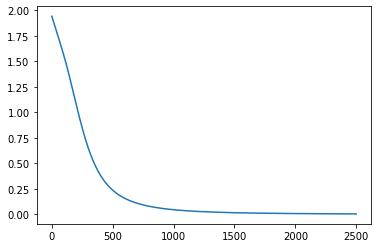

In [11]:
plt.plot(loss_history)
plt.show()

In [12]:
test(gcn)
loss

Accuracy: accuracy= 0.7870


tensor(0.0042, grad_fn=<NllLossBackward>)

In [23]:
outputs.max(1)[1].type_as(labels)

tensor([6, 4, 1,  ..., 3, 2, 6])

In [24]:
labels

tensor([6, 4, 1,  ..., 3, 2, 6])

# (Optional) CUDA-enabled GCN

In [ ]:
import math

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = Parameter(torch.FloatTensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        return output + self.bias

In [ ]:
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout
        
    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [ ]:
gcn = GCN(1433, 50, 7, 0.2)
optimizer_gcn = optim.Adam(gcn.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
gcn.to('cuda')

In [ ]:
import tqdm
loss_history = np.zeros(2500) 

for epoch in tqdm.trange(2500): 
  
    optimizer_gcn.zero_grad()
    outputs = gcn(features.to('cuda'), adj.to('cuda')) # Usiamo tutto il dataset
    loss = criterion(outputs[idx_train].to('cuda'), labels[idx_train].to('cuda')) # Mascheriamo sulla parte di training
    loss.backward()
    optimizer_gcn.step()

    loss_history[epoch] = loss.detach().cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.ylim(0, 0.2)
plt.show()

In [ ]:
from pygcn.utils import accuracy
def test(model):
  y_pred = model(features.to('cuda'), adj.to('cuda')) # Usiamo tutto il dataset
  acc_test = accuracy(y_pred[idx_test], labels[idx_test]) # Mascheriamo sulla parte di test
  print("Accuracy:",
          "accuracy= {:.4f}".format(acc_test.item()))

In [ ]:
test(gcn)